In [ ]:
import pandas as pd
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import re
import string
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
reviewsFile = pd.read_csv("review.csv", encoding='ISO-8859-1')
reviewsData = reviewsFile['review']

# **EDA**

In [ ]:
reviewsFile.shape

(18298, 5)

In [ ]:
reviewsFile.head()

,Unnamed: 0,Name,college,review,rating
0,0,Nimalraj,SNS College of Technology - [SNSCT],"The annual fee for the course is 1,25,000. Now...",6.0
1,1,Priyaranjan kumar,Bhagalpur College of Engineering - [BCE],The hostel life and social life in this colleg...,9.7
2,2,Aftab Shaikh,Shree LR Tiwari College of Engineering - [SLRTCE],I chose this course because I was interested i...,8.0
3,3,Shreya sneh,IILM University,There is IGNITE fest in the university held on...,10.0
4,4,Yuv Raj Singh,Galgotias University - [GU],The civil department is very good in this coll...,6.2


In [ ]:
reviewsFile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18298 entries, 0 to 18297
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  18298 non-null  int64  
 1   Name        18298 non-null  object 
 2   college     18298 non-null  object 
 3   review      18298 non-null  object 
 4   rating      18298 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 714.9+ KB


In [ ]:
reviewsFile.describe()

,Unnamed: 0,rating
count,18298.000000,18298.000000
mean,9148.500000,7.958591
std,5282.321948,1.323115
min,0.000000,1.000000
25%,4574.250000,7.200000
50%,9148.500000,8.000000
75%,13722.750000,8.875000
max,18297.000000,10.000000


In [ ]:
reviewsFile.nunique()

Unnamed: 0    18298
Name          11618
college        2269
review        14427
rating           78
dtype: int64

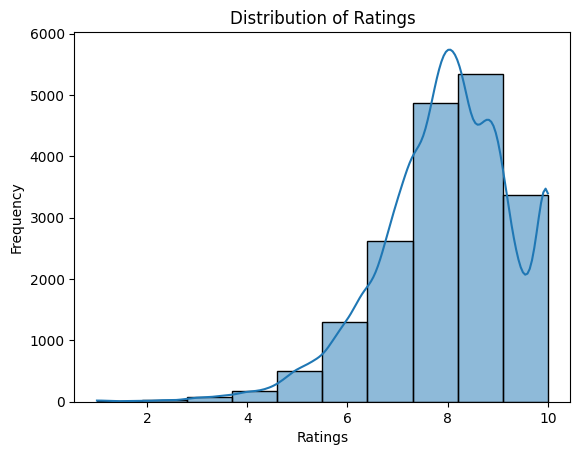

In [ ]:
sns.histplot(reviewsFile['rating'], bins=10, kde=True)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

# **Sentiment Analysis**

In [ ]:
#PRE-PROCESSING TECHNIQUES
rmSpclChar = []

replace_no_space = re.compile("[.;:!\'?,\"()\[\]]")
replace_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
remove_spcl = re.compile("[^\w]")
pattern = '[0-9]'

def preprocess_reviews(reviews):
    reviews = [replace_no_space.sub("", line.lower()) for line in reviews]
    reviews = [replace_with_space.sub(" ", line) for line in reviews]
    reviews = [remove_spcl.sub(" ",line) for line in reviews]
    reviews = [re.sub(pattern,"",line) for line in reviews]
    return reviews

rmSpclChar = preprocess_reviews(reviewsData)

stopWords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Cleaned reviews storage
reviewCleanedData = []

for line in rmSpclChar:
    review = word_tokenize(str(line))
    reviewCleaned = []

    for word in review:
        if word not in stopWords and word not in string.punctuation:
            if '@' not in word and '#' not in word and 'www' not in word:
                lemmatized_word = lemmatizer.lemmatize(word)
                reviewCleaned.append(lemmatized_word)

    reviewCleanedData.append(reviewCleaned)

# Join tokens back into sentences
reviewSentencedData = [" ".join(sentence) for sentence in reviewCleanedData]

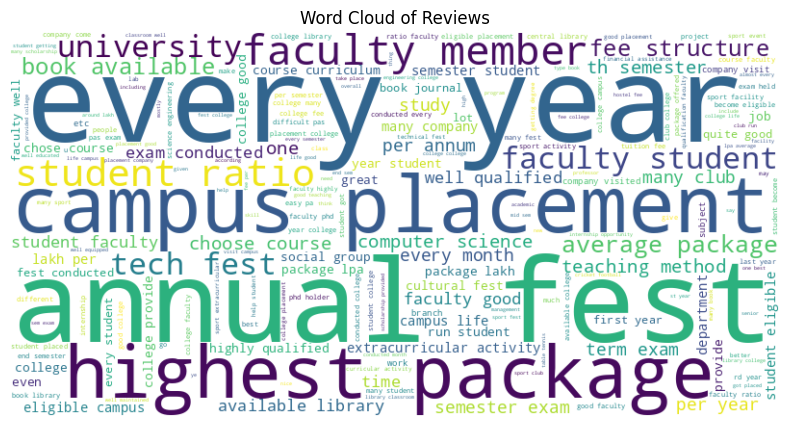

In [ ]:
# Concatenate all reviews into a single string
all_reviews = ' '.join(reviewSentencedData)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

**Model Training**

In [ ]:
reviewData = {'clean_data': reviewSentencedData}
df = pd.DataFrame(reviewData)

In [ ]:
nltk.download('vader_lexicon')

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

reviewsFile['compound_score'] = df['clean_data'].apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
reviewsFile['compound_score']

0        0.5423
1        0.9217
2        0.9001
3        0.6705
4        0.9485
          ...  
18293    0.9674
18294    0.9829
18295    0.9904
18296    0.9694
18297    0.7090
Name: compound_score, Length: 18298, dtype: float64

In [ ]:
# Assuming you have a DataFrame 'df' with columns 'review_description' and 'rating'
X = df['clean_data']
y = reviewsFile['rating']

# Convert ratings to binary sentiment labels (1 for positive, 0 for negative)
y = (y > 3).astype(int)

In [ ]:
#CREATING FILE FOR TESTING-TRAINING

data = {'clean_data': X, 'sentiment': y}
df = pd.DataFrame(data)
df.to_csv('review-data.csv')

In [ ]:
reviewFile1 = pd.read_csv("review-data.csv", encoding='ISO-8859-1')
reviewData1 = reviewFile1['clean_data']

In [ ]:
#TF-IDF VECTORIZATION
vectorizer = TfidfVectorizer(min_df=10, max_df=0.8, sublinear_tf=True, use_idf=True)
train_vectors = vectorizer.fit_transform(reviewFile1['clean_data'].values.astype('U'))

In [ ]:
#STRATIFIEDKFOLD
X=train_vectors
y=reviewFile1['sentiment']
RANDOM_SEED = 1
skf = StratifiedKFold(n_splits=4,random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(X, y)

4

In [ ]:
totalAccuracyScore = 0
totalf1Score = 0
totalRecall = 0
totalPrecision = 0

for train_index, test_index in skf.split(X, y):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model = MultinomialNB()
  model.fit(X_train, y_train)

  # Make predictions on the testing data
  y_pred = model.predict(X_test)

  report = classification_report(y_test, y_pred, output_dict=True)

  accuracyScore = accuracy_score(y_test, y_pred)
  totalAccuracyScore+=accuracyScore

  f1Score = f1_score(y_test, y_pred, average="macro")
  totalf1Score+=f1Score

  recallScore = recall_score(y_test, y_pred, average="macro")
  totalRecall+=recallScore

  precisionScore = precision_score(y_test, y_pred, average="macro")
  totalPrecision+=precisionScore

  RANDOM_SEED += 1

avgAccuracyScore = totalAccuracyScore/4
avgf1Score = totalf1Score/4
avgRecall = totalRecall/4
avgPrecision = totalPrecision/4

print("Accuracy: %fs" % (accuracyScore))
print("Precision: %fs" % (avgPrecision))
print("Recall: %fs" % (avgRecall))
print("f1-score: %fs" % (avgf1Score))

TRAIN: [    2     4     5 ... 18294 18295 18296] TEST: [    0     1     3 ... 18287 18291 18297]
TRAIN: [    0     1     3 ... 18294 18296 18297] TEST: [    2     7    10 ... 18289 18292 18295]
TRAIN: [    0     1     2 ... 18294 18295 18297] TEST: [    5     6    11 ... 18288 18293 18296]
TRAIN: [    0     1     2 ... 18295 18296 18297] TEST: [    4     9    17 ... 18282 18290 18294]
Accuracy: 0.996502s
Precision: 0.498197s
Recall: 0.500000s
f1-score: 0.499097s


In [1]:
!pip install web3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.0/356.0 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 34.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 16.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of eth-account to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.7/355.7 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.1/355.1 kB 34.2 MB/s et

In [2]:
from web3 import Web3
import json

In [15]:
# Replace '<random-string>' with the actual string provided by ngrok
ngrok_url = "https://4e00-2401-4900-1c5b-6550-444f-f480-ea82-8242.ngrok-free.app"
web3 = Web3(Web3.HTTPProvider(ngrok_url))

In [16]:
# Check if connected
if web3.is_connected():
    print("Connected to Ganache via ngrok")
else:
    print("Failed to connect to Ganache via ngrok")

Connected to Ganache via ngrok


In [17]:
# Manually paste the contract ABI here
contract_abi = [
	{
		"inputs": [
			{
				"internalType": "string",
				"name": "accuracy",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "precision",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "recall",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "f1Score",
				"type": "string"
			}
		],
		"name": "storeResults",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "",
				"type": "uint256"
			}
		],
		"name": "results",
		"outputs": [
			{
				"internalType": "string",
				"name": "accuracy",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "precision",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "recall",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "f1Score",
				"type": "string"
			}
		],
		"stateMutability": "view",
		"type": "function"
	}
]

In [18]:
# Address of the deployed contract
contract_address = '0x08732ecc9C9Ac90152fAF4a3405263Cda31E4EEf'

In [19]:
web3 = Web3(Web3.HTTPProvider(ngrok_url))

In [20]:
# Create contract instance
contract = web3.eth.contract(address=contract_address, abi=contract_abi)

In [21]:
# Account to use for transactions (first Ganache account)
account = web3.eth.accounts[5]

In [22]:
# Results to store
#train_data = [2, 4, 5, ..., 18294, 18295, 18296]
#test_data = [0, 1, 3, ..., 18287, 18291, 18297]
accuracy = "0.996502s"
precision = "0.498197s"
recall = "0.500000s"
f1_score = "0.499097s"

In [23]:
# Store results in the contract
tx_hash = contract.functions.storeResults(accuracy, precision, recall, f1_score).transact({'from': account})
web3.eth.wait_for_transaction_receipt(tx_hash)

AttributeDict({'transactionHash': HexBytes('0xeece6ee7ad8194f1bfef4f4492378d00b7c9d6ee58a61ee88f5ab92bb178cf31'),
 'transactionIndex': 0,
 'blockNumber': 3,
 'blockHash': HexBytes('0x258920a217e73d897f998049c0c8799989f27ad5e07225ae5d2e067f52e996ee'),
 'from': '0xd9268789a2A5448772dF8F18C5CF6860D94ea61F',
 'to': '0x08732ecc9C9Ac90152fAF4a3405263Cda31E4EEf',
 'cumulativeGasUsed': 139401,
 'gasUsed': 139401,
 'contractAddress': None,
 'logs': [],
 'logsBloom': HexBytes('0x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'),
 'status':

**Verify the Results**

In [24]:
# Assuming contract instance is already created and ABI is defined as contract_abi

# Specify the index of the result you want to retrieve
index = 0  # Change this to the desired index

# Retrieve stored results
stored_results = contract.functions.results(index).call()

# Print the retrieved results
print("Stored Results:")
print("Accuracy:", stored_results[0])
print("Precision:", stored_results[1])
print("Recall:", stored_results[2])
print("F1 Score:", stored_results[3])

Stored Results:
Accuracy: 0.996502s
Precision: 0.498197s
Recall: 0.500000s
F1 Score: 0.499097s
